In [1]:
import pandas as pd
import numpy as np
import random
import math
random.seed(2020)

# from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold
import matplotlib.pylab as plt
from sklearn import preprocessing

import lightgbm as lgb
# import xgboost as xgb
# from sklearn.linear_model import LogisticRegression
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.ensemble import GradientBoostingClassifier

import missingno as msno
import seaborn as sns

In [2]:
df = pd.read_csv("Train.csv")
# y = df.target
# x = df[["Policy Start Date", "Policy End Date", "Gender", "Age", "First Transaction Date", "No_Pol",
#         "Car_Category", "Subject_Car_Colour", "Subject_Car_Make", "LGA_Name", "State", "ProductName"]]
variables = pd.read_csv("VariableDefinitions.csv")
variables

,ID,Unique ID for the customer
0,Policy Start Date,Date policy started
1,Policy End Date,Date policy ended
2,Gender,Gender of the customer
3,Age,Age of the customer
4,ProductName,Name of Insurance policy
5,First Transaction Date,First date payment was made
6,No_Pol,Number of policies the customer has
7,Car_Category,Type of car
8,Subject_Car_Colour,Car colour
9,Subject_Car_Make,Car make


In [3]:
x = pd.read_csv('Train.csv')
y = x['target'] ; idx_tr = x['ID'] ;
del x['ID'] ; x['First Transaction Date']
# print (x.shape)
#------------------------------Delete duplicated rows--------------------------------------
# with same Target
# print ("Delete duplicated rows:")
num_rows = x.shape[0]
to_del = x.duplicated(keep='first')
x = x[~to_del] ; y = y[~to_del] ; 
# print ("\t*with same Target:",(num_rows-x.shape[0])) 
# With different target
del x['target']
num_rows = x.shape[0]
x_ = x[x.duplicated(keep=False)]
x.drop(x_.index, inplace=True) ; y.drop(x_.index, inplace=True)
# print ("\t*with diff Target:",(num_rows-x.shape[0])) 
# print (x.shape,y.shape)

In [4]:
colors = ['Black', 'Silver', 'Grey', 'Blue', 'White', 'Red', 'Green', 'Gold', 'Ash', 'Wine', 'Brown']
def replace_color(color):
    if color not in colors:
        return random.choice(colors)
    return color
x.Subject_Car_Colour = x.Subject_Car_Colour.apply(replace_color)
le1 = preprocessing.LabelEncoder()
x.Subject_Car_Colour = le1.fit_transform(x.Subject_Car_Colour)

In [5]:
cars = ['Saloon', 'JEEP', 'Truck', 'Bus', 'Mini Bus', 'Pick Up', 'Motorcycle', 'Mini Van', 'Sedan', 'Wagon']
def replace_car(car):
    if car not in cars:
        return random.choice(cars)
    return car
x.Car_Category = x.Car_Category.apply(replace_car)
le2 = preprocessing.LabelEncoder()
x.Car_Category = le2.fit_transform(x.Car_Category)

In [6]:
ages = x.Age.sort_values()
ages[3427] = 60
ages[3518] = 59
ages[5173] = 59
ages[909] = 76
ages[10713] = 76
ages = ages.sort_values()

def fillwith42(x):
    if x >= 15 and x <= 18:
        return 16
    elif x >= 18 and x <= 93:
        return x
    else:
        return 42
    
ages = ages.apply(lambda age: -age if age < 0 else age)
ages = ages.apply(fillwith42)
ages = ages.sort_values()
x.Age = ages

In [7]:
def other_gender(gender):
    if gender not in ["Male", "Female"]:
        return "Other"
    return gender

x.Gender = x.Gender.apply(other_gender)

legender = preprocessing.LabelEncoder()
x.Gender = legender.fit_transform(x.Gender)

In [8]:
le3 = preprocessing.LabelEncoder()
x.ProductName = le3.fit_transform(x.ProductName)

In [9]:
car_brands = ['TOYOTA', 'Honda', 'Lexus', 'Mercedes', 'Hyundai', 'Kia', 'Ford', 'Nissan', 'Volkswagen', 'Range Rover', 'Mitsubishi', 'Iveco', 'BMW', 'ACURA', 'Land Rover', 'Mazda', 'Peugeot', 'Volvo', 'Mack', 'Audi', 'Pontiac', 'Infiniti', 'Chevrolet']
x.Subject_Car_Make = x.Subject_Car_Make.apply(lambda x: x if x in car_brands else "other")
le4 = preprocessing.LabelEncoder()
x.Subject_Car_Make = le4.fit_transform(x.Subject_Car_Make)

In [10]:
lgalist = ['Victoria Island', 'Ikeja', 'Surulere', 'Lagos Island', 'Eti-Osa', 'Lagos Mainland', 'Lekki', 'Abuja Municipal', 'Lagos', 'Ibeju/Lekki', 'Oshodi-Isolo', 'Obia/Akpor', 'Kosofe', 'Abuja', 'Ikoyi', 'Alimosho', 'Benin', 'Amuwo-Odofin', 'Shomolu', 'Port Harcourt', 'Agege', 'Apapa', 'Ikorodu', 'Yaba', 'Port-Harcourt', 'GBAGADA', 'Festac', 'Ajah', 'OGBA', 'Ifako-Ijaye ', 'Ibadan North West', 'Warri Central', 'Central', 'OGUN', 'Warri', 'Ilupeju', 'ENUGU EAST', 'Oredo', 'Ketu', 'Asaba', 'Kaduna North', 'Ibadan South West', 'IBADAN NORTH EAST', 'Oguta', 'Mushin', 'ISHERI', 'OGUDU', 'Abeokuta', 'Ojodu', 'Ife Central', 'Egbeda', 'Isolo', 'Owerri-Municipal', 'Osogbo', 'Maryland', 'Kaduna', 'Ifo', 'Uyo', 'Jos North', 'LGA', 'Kaduna South', 'Oshodi', 'MAGODO', 'Jos South']
x.LGA_Name = x.LGA_Name.apply(lambda x: x if x in lgalist else "other")
le5 = preprocessing.LabelEncoder()
x.LGA_Name = le5.fit_transform(x.LGA_Name)

In [11]:
states = ['Lagos', 'Benue', 'Eti-Osa', 'Abuja-Municipal', 'Ibeju-Lekki', 'Obia-Akpor', 'Oshodi-Isolo', 'Abuja', 'Delta', 'Ogun', 'Edo', 'Amuwo-Odofin', 'Rivers', 'Ibadan-West', 'Port-Harcourt', 'Oyo', 'Ifako-Ijaye', 'Warri-Central', 'Imo', 'ENUGU-EAST', 'Kaduna-North', 'Akwa-Ibom', 'Anambra', 'Osun', 'Ife-Central', 'Niger-State', 'Owerri-Municipal', 'Kaduna', 'Jos-North', 'Jos-South', 'Kaduna-South', 'Anambra-East', 'Ijebu-Ode', 'Enugu-North', 'Ogbmosho-South', 'Ibadan-East', 'Ondo', 'Lagelu-North', 'Ajeromi-Ifelodun', 'Nnewi-North', 'Kano-Municipal', 'Nsit-Ubium', 'ABULE-EGBA', 'Ibadan-North', 'Obafemi-Owode', 'Ogun-Waterside', 'Ado-Ota', 'Aba-North', 'Warri-North', 'Udi-Agwu', 'Aniocha-South', 'Awka-South', 'Onitsha-North', 'Esan-West']
x.State = x.State.apply(lambda x: x if x in states else "other")
le6 = preprocessing.LabelEncoder()
x.State = le6.fit_transform(x.State)

In [12]:
# x["Policy Start Date"] = pd.to_datetime(x["Policy Start Date"], format = "%Y-%m-%d")
# x["Policy End Date"] = pd.to_datetime(x["Policy End Date"], format = "%Y-%m-%d")

# x["start_yearmonth"] = -((2022 - x["Policy Start Date"].dt.year)*100 + x["Policy Start Date"].dt.month)
# x["end_yearmonth"] = (-x["Policy End Date"].dt.year)*100 + x["Policy End Date"].dt.month

# x["start_yearweek"] = 

<AxesSubplot:>

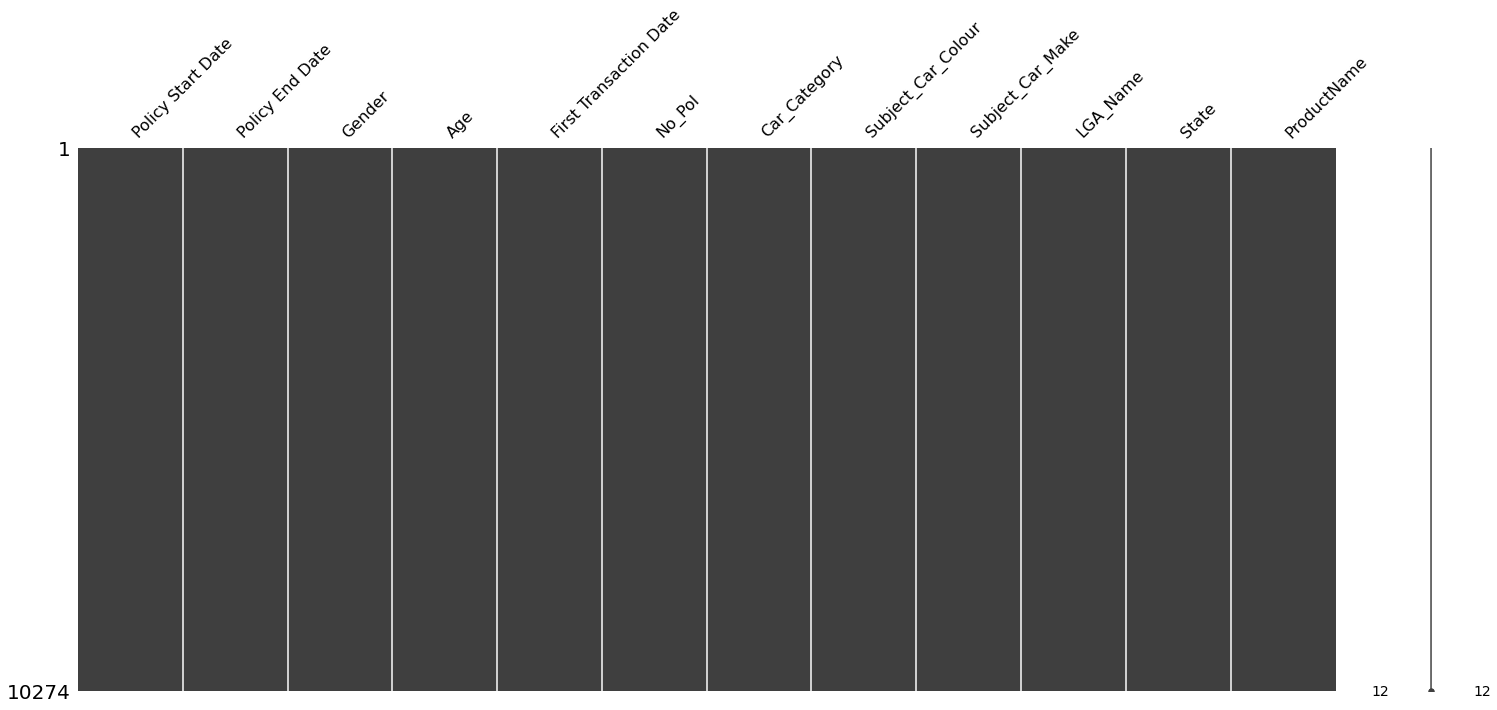

In [13]:
msno.matrix(x)

In [14]:
def lgb_f1_score(y_hat, data):
    y_true = data.get_label()
    y_hat = np.round(y_hat)
    return 'f1', f1_score(y_true, y_hat), True

In [15]:
x

,Policy Start Date,Policy End Date,Gender,Age,First Transaction Date,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,LGA_Name,State,ProductName
0,2010-05-14,2011-05-13,1,30,2010-05-14,1,6,1,20,64,54,1
1,2010-11-29,2011-11-28,0,79,2010-11-29,1,1,6,20,64,54,1
2,2010-03-21,2011-03-20,1,43,2010-03-21,1,6,7,20,64,54,1
3,2010-08-21,2011-08-20,1,42,2010-08-21,1,2,10,23,64,54,5
5,2010-10-21,2011-10-20,1,37,2010-10-21,2,2,10,23,64,54,1
...,...,...,...,...,...,...,...,...,...,...,...,...
12074,2010-05-25,2011-05-24,0,30,2010-05-25,1,6,1,19,20,22,1
12075,2010-10-03,2011-10-02,0,59,2010-10-03,1,4,1,23,64,54,1
12076,2010-10-10,2011-10-08,1,34,2010-10-10,1,8,8,23,64,54,5
12077,2010-02-27,2011-02-26,2,42,2010-02-27,2,6,9,20,60,34,0


In [16]:
x[["Policy Start Date", "Policy End Date", "First Transaction Date",
   "Subject_Car_Make", "LGA_Name", "State", "ProductName"]] = x[["Policy Start Date", "Policy End Date", "First Transaction Date",
   "Subject_Car_Make", "LGA_Name", "State", "ProductName"]].astype("category")

In [17]:
score = 0
kf = StratifiedKFold(n_splits = 5, shuffle = True, random_state=2020)
evals_results = {}
for train_index, test_index in kf.split(x, y):
    x_train, x_test = x.iloc[train_index], x.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    lgtrain = lgb.Dataset(x_train, y_train)
    lgval = lgb.Dataset(x_test, y_test)
    
    model = lgb.train({'metric':[lgb_f1_score], 'objective': 'binary'},
                     train_set=lgtrain, 
                     valid_sets= [lgval], 
                     valid_names=['valid'], 
                     evals_result=evals_results, 
                     num_boost_round=5000,
                     early_stopping_rounds=100,
                     verbose_eval=-1, 
                     feval=lgb_f1_score
                     )
    y_pred = model.predict(x_test)
    scorep = f1_score(np.where(y_pred < 0.5, 0, 1)  , y_test)
    score += scorep
print("lightgbm mean f1_score:", score/5)

C:\Users\ZAKARIA.CHOUKRI\AppData\Roaming\Python\Python310\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\ZAKARIA.CHOUKRI\AppData\Roaming\Python\Python310\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\ZAKARIA.CHOUKRI\AppData\Roaming\Python\Python310\site-packages\lightgbm\engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' cal

[LightGBM] [Warning] Unknown parameter: lgb_f1_score
[LightGBM] [Warning] Unknown parameter: 0x00000222EF39C160>
[LightGBM] [Warning] Unknown parameter: at
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: lgb_f1_score
[LightGBM] [Warning] Unknown parameter: 0x00000222EF39C160>
[LightGBM] [Warning] Unknown parameter: at
[LightGBM] [Info] Number of positive: 567, number of negative: 7652
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000300 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1257
[LightGBM] [Info] Number of data points in the train set: 8219, number of used features: 12
[LightGBM] [Warning] Unknown parameter: lgb_f1_score
[LightGBM] [Warning] Unknown parameter: 0x00000222EF39C160>
[LightGBM] [Warning] Unknown parameter: at
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [I

C:\Users\ZAKARIA.CHOUKRI\AppData\Roaming\Python\Python310\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\ZAKARIA.CHOUKRI\AppData\Roaming\Python\Python310\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\ZAKARIA.CHOUKRI\AppData\Roaming\Python\Python310\site-packages\lightgbm\engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' cal

Early stopping, best iteration is:
[102]	valid's f1: 0.301075
[LightGBM] [Warning] Unknown parameter: lgb_f1_score
[LightGBM] [Warning] Unknown parameter: 0x00000222EF39C160>
[LightGBM] [Warning] Unknown parameter: at
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: lgb_f1_score
[LightGBM] [Warning] Unknown parameter: 0x00000222EF39C160>
[LightGBM] [Warning] Unknown parameter: at
[LightGBM] [Info] Number of positive: 566, number of negative: 7653
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000399 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1260
[LightGBM] [Info] Number of data points in the train set: 8219, number of used features: 12
[LightGBM] [Warning] Unknown parameter: lgb_f1_score
[LightGBM] [Warning] Unknown parameter: 0x00000222EF39C160>
[LightGBM] [Warning] Unknown parameter: at
[LightGBM] [Warning] Found whit

C:\Users\ZAKARIA.CHOUKRI\AppData\Roaming\Python\Python310\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\ZAKARIA.CHOUKRI\AppData\Roaming\Python\Python310\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\ZAKARIA.CHOUKRI\AppData\Roaming\Python\Python310\site-packages\lightgbm\engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' cal

Early stopping, best iteration is:
[243]	valid's f1: 0.237113
[LightGBM] [Warning] Unknown parameter: lgb_f1_score
[LightGBM] [Warning] Unknown parameter: 0x00000222EF39C160>
[LightGBM] [Warning] Unknown parameter: at
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: lgb_f1_score
[LightGBM] [Warning] Unknown parameter: 0x00000222EF39C160>
[LightGBM] [Warning] Unknown parameter: at
[LightGBM] [Info] Number of positive: 566, number of negative: 7653
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000414 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1262
[LightGBM] [Info] Number of data points in the train set: 8219, number of used features: 12
[LightGBM] [Warning] Unknown parameter: lgb_f1_score
[LightGBM] [Warning] Unknown parameter: 0x00000222EF39C160>
[LightGBM] [Warning] Unknown parameter: at
[LightGBM] [Warning] Found whit

C:\Users\ZAKARIA.CHOUKRI\AppData\Roaming\Python\Python310\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\ZAKARIA.CHOUKRI\AppData\Roaming\Python\Python310\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\ZAKARIA.CHOUKRI\AppData\Roaming\Python\Python310\site-packages\lightgbm\engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' cal

Early stopping, best iteration is:
[104]	valid's f1: 0.217617
[LightGBM] [Warning] Unknown parameter: lgb_f1_score
[LightGBM] [Warning] Unknown parameter: 0x00000222EF39C160>
[LightGBM] [Warning] Unknown parameter: at
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: lgb_f1_score
[LightGBM] [Warning] Unknown parameter: 0x00000222EF39C160>
[LightGBM] [Warning] Unknown parameter: at
[LightGBM] [Info] Number of positive: 567, number of negative: 7653
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000399 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1259
[LightGBM] [Info] Number of data points in the train set: 8220, number of used features: 12
[LightGBM] [Warning] Unknown parameter: lgb_f1_score
[LightGBM] [Warning] Unknown parameter: 0x00000222EF39C160>
[LightGBM] [Warning] Unknown parameter: at
[LightGBM] [Warning] Found whit

C:\Users\ZAKARIA.CHOUKRI\AppData\Roaming\Python\Python310\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\ZAKARIA.CHOUKRI\AppData\Roaming\Python\Python310\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\ZAKARIA.CHOUKRI\AppData\Roaming\Python\Python310\site-packages\lightgbm\engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' cal

Early stopping, best iteration is:
[149]	valid's f1: 0.285714
lightgbm mean f1_score: 0.25346519770342596


In [18]:
# score = 0
# kf = StratifiedKFold(n_splits = 5, shuffle = True, random_state=2020)
# for train_index, test_index in kf.split(x, y):
#     x_train, x_test = x.loc[train_index], x.loc[test_index]
#     y_train, y_test = y.loc[train_index], y.loc[test_index]
#     # model = lgb.LGBMClassifier(metric = [lgb_f1_score])
#     model = lgb.LGBMClassifier()
#     model.fit(x_train, y_train)
#     y_pred = model.predict(x_test)
#     scorep = f1_score(y_pred, y_test)
#     score += scorep
# print("lightgbm mean f1_score:", score/5)